In [1]:
!pip install tf-keras-vis

     |████████████████████████████████| 52 kB 1.1 MB/s 


In [2]:
import tensorflow as tf
from keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import keras
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import glob

In [3]:
model_path = '/kaggle/input/rib-suppression/keras/default/1/epoch-20-0.00.hdf5'
rib_suppression = keras.models.load_model(model_path)
rib_suppression.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [4]:
main_path = "/kaggle/input/rib-supressed-split/rib_suppressed_split"

In [5]:
train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")
val_path=os.path.join(main_path,"val")

Displaying Before-and-After Bone Suppression:


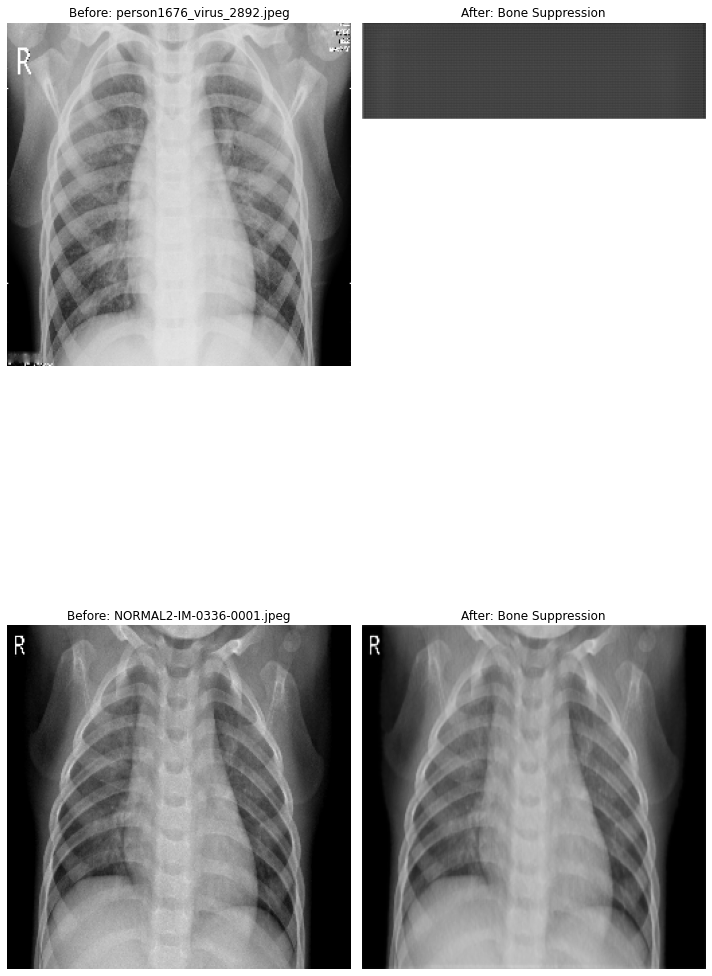

In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print("Displaying Before-and-After Bone Suppression:")
orig_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

test_pneumonia_files = glob.glob(orig_path + "/PNEUMONIA/*.jpeg")[:1]
test_normal_files = glob.glob(orig_path + "/NORMAL/*.jpeg")[:1]
sample_paths = test_pneumonia_files + test_normal_files

plt.figure(figsize=(10, 20))

for i, img_path in enumerate(sample_paths):

    img_orig = load_img(img_path, target_size=(256, 256), color_mode='grayscale')
    img_array_orig = img_to_array(img_orig)

    img_rescaled = img_array_orig / 255.0
    
    suppressed_img_array = rib_suppression.predict(np.expand_dims(img_rescaled, axis=0))[0]
    

    suppressed_img_array = np.clip(suppressed_img_array, 0, 1)
    
    plt.subplot(len(sample_paths), 2, i*2 + 1)
    plt.imshow(img_array_orig.squeeze(), cmap='gray')
    plt.title(f"Before: {os.path.basename(img_path)}")
    plt.axis('off')
    
    plt.subplot(len(sample_paths), 2, i*2 + 2)
    plt.imshow(suppressed_img_array.squeeze(), cmap='gray')
    plt.title("After: Bone Suppression")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
pneumonia_train_images = glob.glob(train_path+"/PNEUMONIA/*.jpeg")
normal_train_images = glob.glob(train_path+"/NORMAL/*.jpeg")

In [8]:
data = pd.DataFrame(np.concatenate([[0]*len(normal_train_images) , [1] *  len(pneumonia_train_images)]),columns=["class"])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='class', ylabel='count'>

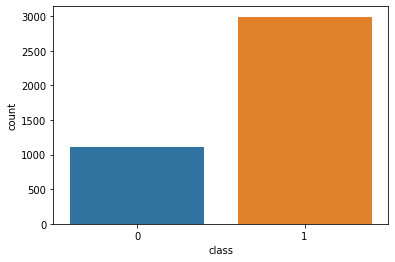

In [9]:
sns.countplot(data['class'],data=data)

In [10]:
train_Datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range = 30,
    shear_range=10,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'nearest',
)
val_datagen = ImageDataGenerator(
    rescale=1/255,
)

In [11]:
import keras.backend as K

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, Multiply

def SqueezeAndExcite(inputs, ratio=16):
    c = inputs.shape[-1]
    
    # Squeeze
    x = GlobalAveragePooling2D()(inputs)
    
    # Excitation
    x = Dense(c // ratio, activation='relu', use_bias=False)(x)
    x = Dense(c, activation='sigmoid', use_bias=False)(x)

    x = Reshape((1, 1, c))(x)
    x = Multiply()([inputs, x])
    
    return x

In [12]:
conv_base = VGG16(include_top = False,weights='imagenet')
for i in conv_base.layers:
    i.trainable=False
X = conv_base.output
X = keras.layers.GlobalAveragePooling2D()(X)
X = keras.layers.Dense(128,activation='relu')(X)
X = keras.layers.Dense(64,activation='relu')(X)
predictions = keras.layers.Dense(1,activation='sigmoid')(X)
model= keras.Model(conv_base.input,predictions)
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(lr_schedule),
             metrics=['accuracy'])

58892288/58889256 [==============================] - 2s 0us/step


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [14]:
train_generator=train_Datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size= 32,
    class_mode='binary',
    color_mode='rgb'
)
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        color_mode='rgb'
)
test_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

Found 4099 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


# Fitting the model

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch = 20,
    epochs=50,
    validation_data = validation_generator,
)

Epoch 1/50
20/20 [==============================] - 97s 5s/step - loss: 0.6825 - accuracy: 0.6138 - val_loss: 0.5996 - val_accuracy: 0.8607
Epoch 2/50
20/20 [==============================] - 83s 4s/step - loss: 0.5354 - accuracy: 0.7260 - val_loss: 0.4107 - val_accuracy: 0.8239
Epoch 3/50
20/20 [==============================] - 84s 4s/step - loss: 0.3282 - accuracy: 0.8526 - val_loss: 0.2919 - val_accuracy: 0.8735
Epoch 4/50
20/20 [==============================] - 84s 4s/step - loss: 0.3817 - accuracy: 0.8329 - val_loss: 0.2635 - val_accuracy: 0.8923
Epoch 5/50
20/20 [==============================] - 84s 4s/step - loss: 0.2985 - accuracy: 0.8541 - val_loss: 0.4021 - val_accuracy: 0.8291
Epoch 6/50
20/20 [==============================] - 84s 4s/step - loss: 0.2956 - accuracy: 0.8713 - val_loss: 0.3021 - val_accuracy: 0.8675
Epoch 7/50
20/20 [==============================] - 83s 4s/step - loss: 0.2465 - accuracy: 0.9145 - val_loss: 0.3552 - val_accuracy: 0.8496
Epoch 8/50
20/20 [==

In [16]:
accuracy=model.evaluate_generator(test_generator,624)[1]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [17]:
accuracy

0.9080067873001099

# Unfreezing last few layers of the model


In [18]:
for layer in conv_base.layers[-4:]:
    layer.trainable = True

# Finetuning the model
Again training the model with slower learning rate

In [19]:
initial_learning_rate = 1e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), 
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [20]:
new_model = model.fit(
    train_generator,
    steps_per_epoch = 50,
    epochs=25,
    validation_data = validation_generator,
)

Epoch 1/25
50/50 [==============================] - 131s 3s/step - loss: 0.3892 - binary_accuracy: 0.8868 - val_loss: 0.2359 - val_binary_accuracy: 0.8906
Epoch 2/25
50/50 [==============================] - 128s 3s/step - loss: 0.2151 - binary_accuracy: 0.9086 - val_loss: 0.1769 - val_binary_accuracy: 0.9325
Epoch 3/25
50/50 [==============================] - 129s 3s/step - loss: 0.1970 - binary_accuracy: 0.9236 - val_loss: 0.1927 - val_binary_accuracy: 0.9103
Epoch 4/25
50/50 [==============================] - 128s 3s/step - loss: 0.1830 - binary_accuracy: 0.9260 - val_loss: 0.2119 - val_binary_accuracy: 0.9051
Epoch 5/25
50/50 [==============================] - 128s 3s/step - loss: 0.2003 - binary_accuracy: 0.9264 - val_loss: 0.1586 - val_binary_accuracy: 0.9333
Epoch 6/25
50/50 [==============================] - 128s 3s/step - loss: 0.1887 - binary_accuracy: 0.9284 - val_loss: 0.1636 - val_binary_accuracy: 0.9325
Epoch 7/25
50/50 [==============================] - 128s 3s/step - los

In [21]:
final_accuracy = model.evaluate_generator(test_generator,624)[1]

In [22]:
final_accuracy

0.918228268623352

## Metrics

In [23]:
eval_datagen = ImageDataGenerator(rescale=1./255)

test_generator_eval = eval_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,     
    class_mode='binary',
    color_mode='rgb',
    shuffle=False      
)

Found 587 images belonging to 2 classes.


In [24]:
import numpy as np

predictions = model.predict(test_generator_eval, verbose=1)

predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

true_classes = test_generator_eval.classes
class_labels = list(test_generator_eval.class_indices.keys())

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print("-" * 30)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("-" * 30)

19/19 [==============================] - 27s 2s/step
------------------------------
Precision: 0.9974
Recall:    0.8902
F1-Score:  0.9407
------------------------------


# Visualizing the train and validation accuracy and loss

In [25]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [26]:
updated_accuracy = new_model.history['binary_accuracy']
updated_val_accuracy  = new_model.history['val_binary_accuracy']

updated_loss = new_model.history['loss']
updated_val_loss = new_model.history['val_loss']

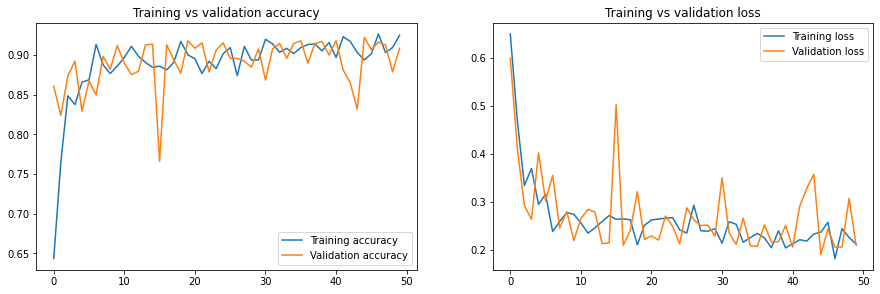

In [27]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")

plt.legend()
plt.title("Training vs validation loss")

plt.show()

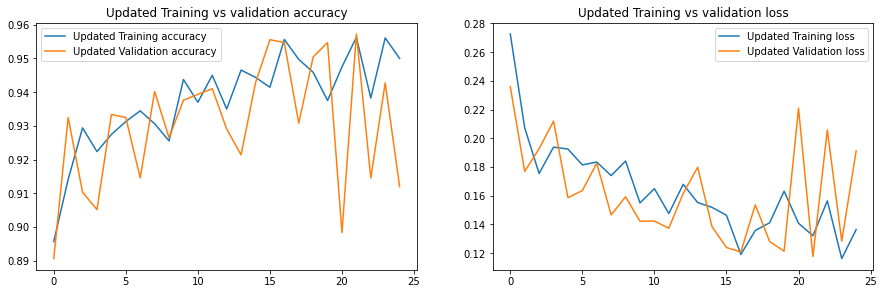

In [28]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(updated_accuracy, label = "Updated Training accuracy")
plt.plot(updated_val_accuracy, label="Updated Validation accuracy")
plt.legend()
plt.title("Updated Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(updated_loss, label = "Updated Training loss")
plt.plot(updated_val_loss, label="Updated Validation loss")

plt.legend()
plt.title("Updated Training vs validation loss")

plt.show()

## GradCAM

In [29]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore

replace2linear = ReplaceToLinear()
score = BinaryScore(1)

In [30]:
pneumonia_samples = glob.glob(test_path + "/PNEUMONIA/*.jpeg")[:3]
normal_samples = glob.glob(test_path + "/NORMAL/*.jpeg")[:3]
sample_images = pneumonia_samples + normal_samples

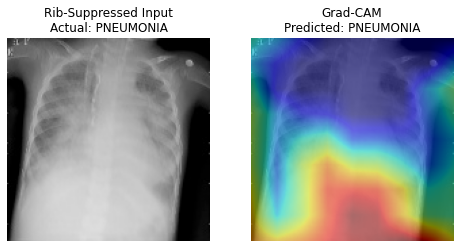

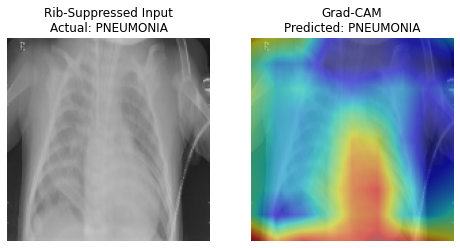

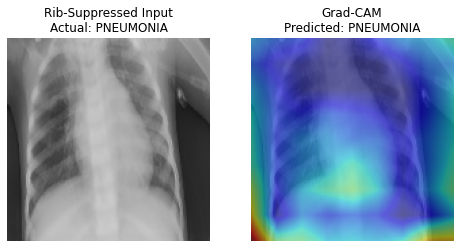

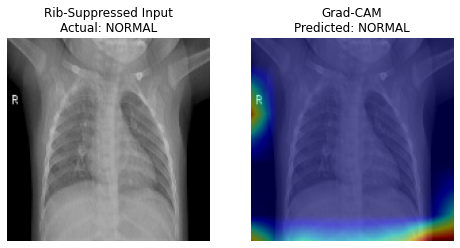

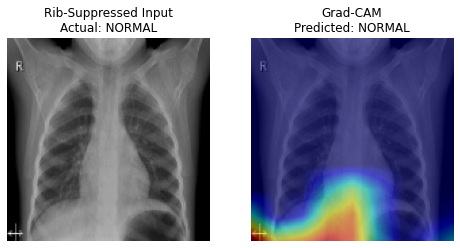

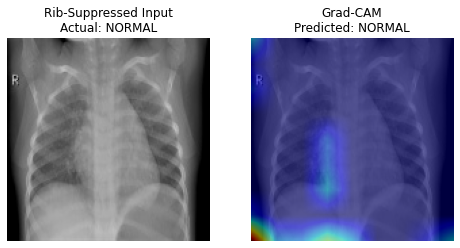

In [31]:
cam = Gradcam(model,
              model_modifier=replace2linear,
              clone=False)

def generate_and_display_heatmap(img_path):

    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img)

    preprocessed_img = np.expand_dims(img_array, axis=0) / 255.0

    cam_map = cam(score, preprocessed_img)

    prediction = model.predict(preprocessed_img)[0][0]
    prediction_class = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Rib-Suppressed Input\nActual: {os.path.basename(os.path.dirname(img_path))}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    heatmap = np.uint8(plt.cm.jet(cam_map[0])[..., :3] * 255)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5) 
    plt.title(f"Grad-CAM\nPredicted: {prediction_class}")
    plt.axis('off')
    
    plt.show()

for img_path in sample_images:
    generate_and_display_heatmap(img_path)